# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 18 апреля 2018, 06:00 <br\>
**Штраф за опоздание:** -3 балла после 06:00 18 апреля, -6 баллов после 06:00 25 апреля, -9 баллов после 06:00 2 мая

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [11]:
USER_NAME = u"Аладушкин".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

Имплементируйте обучение логистической регрессии с L1 регуляризацией с помощью метода  Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь
$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log(\sigma(y^{(i)} g(x^{(i)}))\right] + \frac{1}{C}\sum_{j=1}^{m}|w_j| $$
могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Реализация модели

## Вывод правила обновления весов (1 балл)

Выведите правило обновления весов на каждом шаге алгоритма. Иными словами, посчитайте производную (градиент) функции потерь с регуляризацией. Формулы надо оформлять в формате LaTeX.

Переобозначим.
$$ L(w) = -\frac{1}{N} \left[ \sum\limits_i \log(\sigma(y^{(i)} g(x^{(i)}))) \right] + \frac{1}{C}\sum_{j=1}^{m}|w_j|$$
$$ \sigma(z) = \frac{1}{1+e^{-z}},\quad g(x) = w_0 + (w ,x) $$
Тогда 
$$ \frac{\partial L}{\partial w_i} = \frac{1}{N}\sum_{j}(\sigma(y^{(j)}g(x^{(j)})) - 1)y^{(j)} x^{(j)}_i + \frac{1}{C}sign(w_i)$$

## Имплементация (5 баллов)

In [159]:
from sklearn.base import BaseEstimator, ClassifierMixin


def sigmoid(z):
    return 1. / (1 + np.exp(-z))


class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """

    def __init__(self, C=1, alpha=0.01, max_epoch=10):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """

        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch

    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        X = np.c_[np.ones(X.shape[0]), X]
        self.epoch = 0
        self.w = np.zeros(X.shape[1])
        self.loss_f = np.empty(self.max_epoch)

        for ep in range(self.max_epoch):
            self.epoch += 1
            alpha = self.alpha / self.epoch

            for i in np.random.permutation(X.shape[0]):
                grad = (sigmoid(np.dot(X[i], self.w)) - y[i]) * X[i]
                self.w -= alpha * grad
            self.w -= alpha * np.sign(self.w) / self.C

            s = sigmoid(np.dot(X, self.w))
            self.loss_f[self.epoch - 1] = np.mean(-y * np.log(s) - (1 - y) * np.log(1 - s))

        return self

    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
        return self

    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        X = np.c_[np.ones(X.shape[0]), X]
        y_hat = (np.dot(X, self.w) > 0)
        return y_hat

    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        X = np.c_[np.ones(X.shape[0]), X]
        y_hat_proba = sigmoid(np.dot(X, self.w))
        return y_hat_proba


## Проверка на синтетических данных (1 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

accuracy  0.895
model weights: w0= -3.60226166324 , w1= 0.828215192794 , w2= -0.8360596761


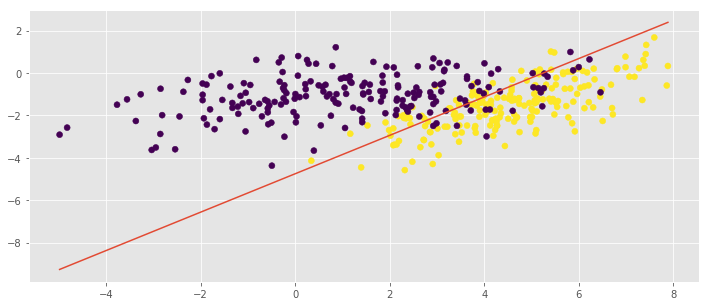

In [160]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

model = MySGDClassifier(alpha=0.05, C=1.0, max_epoch=20)
model.fit(X, y)
print 'accuracy ', accuracy_score(y, model.predict(X))
print 'model weights: w0=', model.w[0], ', w1=', model.w[1], ', w2=', model.w[2]

plt.scatter(X[:, 0], X[:, 1], c=y)
X_help = np.linspace(X[:, 0].min(), X[:, 0].max(), num=2)
plt.plot(X_help, - (clf.w[0] + clf.w[1] * X_help) / clf.w[2])
plt.show()

## Анализ сходимости (2 балла)

Для следующих заданий используйте датасет ниже

In [161]:
from sklearn.datasets import make_classification

In [162]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

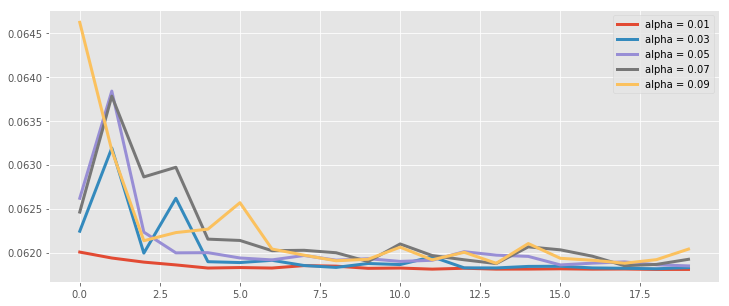

In [163]:
alphas = [0.01, 0.03, 0.05, 0.07, 0.09]
for a in alphas:
    model = MySGDClassifier(alpha=a, C=1.0, max_epoch=20)
    model.fit(X, y)
    plt.plot(model.loss_f, label='alpha = {}'.format(a), linewidth=3)
plt.legend()
plt.show()

## Эффект регуляризации (2 балла)

Изобразите значения коэффициентов модели для каждого С из `np.logspace(3, -3, 10)` (желательно на одном и том же графике)

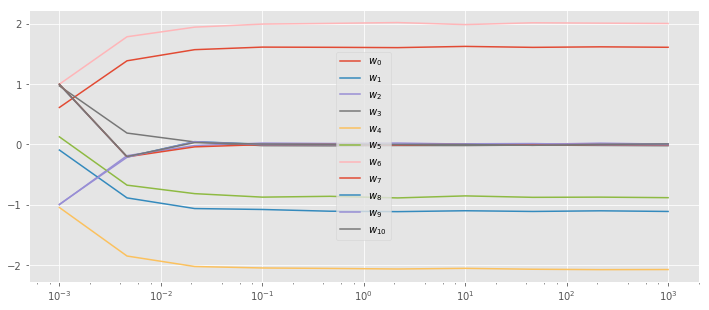

In [164]:
C = np.logspace(3, -3, 10)
weights = np.empty([10, X.shape[1] + 1])
for i in xrange(len(C)):
    model = MySGDClassifier(alpha=0.001, C=C[i], max_epoch=1)
    model.fit(X, y)
    weights[i] = model.w

for i in xrange(weights.shape[1]):
    plt.plot(C, weights[:, i], label='$w_{%d}$' % i)
    plt.xscale('log')
plt.legend()
plt.show()

# Боевое применение

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если все данные не будут помещаться вам с оперативную память, то можете использовать один из 4х файлов для обучения

In [165]:
# Загрузка данных целиком
# df_list = []
# for chunk in range(1,5):
#     filepath = './trainingData_tabular_chunk%d.csv' % chunk
#     df_list.append(pd.read_csv(filepath, sep=','))
# df_data = pd.concat(df_list)

# Загрузка одной части данных
filepath = './trainingData_tabular_chunk1.csv'
df_data = pd.read_csv(filepath, sep=',')

In [166]:
df_data.shape

(500000, 45)

In [167]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [169]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.504702

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы


In [172]:
print 'player:   ', df_data.player_hero_card_id.nunique()
print 'opponent: ', df_data.opponent_hero_card_id.nunique()

player_hero_id = pd.get_dummies(df_data.player_hero_card_id, prefix='player_hero_id')
opponent_hero_id = pd.get_dummies(df_data.opponent_hero_card_id, prefix='opponent_hero_id')
df_data = pd.concat([df_data, player_hero_id, opponent_hero_id], axis=1)

df_data = df_data.drop(["opponent_hero_card_id", "player_hero_card_id"], axis=1)
df_data.head().T

 player:    9
opponent:  9


gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1
opponent_deck_count,11,19,22,17,12


## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Создайте Pipeline из `StandartScaller` и вашей модели
* Обучите модель (подбирать гиперпараметры можно без фанатизма)

In [173]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [174]:
X = df_data.values[:, 1:]
y = df_data.decision.values

model = Pipeline([('scaler', StandardScaler()), ('classifier', MySGDClassifier(max_epoch=1, C=10, alpha=0.001))])
model.fit(X, y)

C:\Users\danil\Anaconda2\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', MySGDClassifier(C=10, alpha=0.001, max_epoch=1))])

## Применение модели (2 балла)
#### Задание
* Загрузите тестовые данные
* Подготовте их к подаче на вход в алгоритм
* Примените модель оцените качество с помощью меры ROC-AUC


In [184]:
filepath = './testData_tabular_chunk5.csv'
data = pd.read_csv(filepath, sep=',')
data_test = data[:50000]

data_test.columns = data_test.columns.str.replace('.', '_')
data_test = data_test.set_index('gamestate_id')

player_hero_id = pd.get_dummies(data_test.player_hero_card_id, prefix='player_hero_id')
opponent_hero_id = pd.get_dummies(data_test.opponent_hero_card_id, prefix='opponent_hero_id')
data_test = pd.concat([data_test, player_hero_id, opponent_hero_id], axis=1)

data_test = data_test.drop(["opponent_hero_card_id", "player_hero_card_id"], axis=1)

In [185]:
from sklearn.metrics import roc_curve, auc

0.786065552755


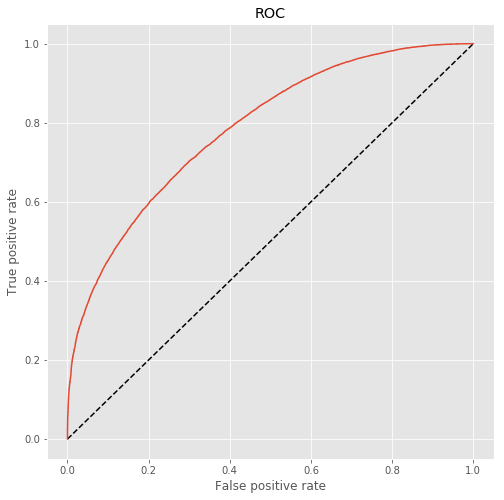

In [186]:
X_test = data_test.values[:, 1:]
y_test = pd.read_table('deprecated_testLabels.txt', names=['decision'])
y_test = y_test[:50000]

y_proba = model.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
print roc_auc

plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC')
plt.plot(fpr, tpr)
plt.show()